# Description of the mini-project

## Dataset

In this mini-project we will work with a dataset used in the *EE-490 Lab in Data Science* course. It is composed of CO2 measurements taken from a pool of 46 cheap but inaccurate sensors deployed in the city of Zurich. In addition, we also have access to temperature and humidity measurements, the altitude of the sensor as well as the average daily wind pattern for the city.

## Prior Knowledge

Measurements highly depends on the temperature, the humidity, the wind, the altitude and the level of traffic around the site. For example, a sensor that is located in a mountain with high altitude and exposed to strong winds is expected to have a much lower and uniform level of CO2 compared to another sensor that is located near the center of the city and close to a busy industrial zone exposed to high traffic activity. We also know that there is a strong dependence of the CO2 measurements on the temperature and the humidity.

## Assumption

Sensors in similar conditions are expected to have similar measurements.

## Issue

It might be the case that one sensor suddenly begins to take wrong measurements. The detection of faulty sensors is done by an external domain expert. Then, our job consists in curate the CO2 measurements for that particular sensor through our regression model.

## Goal

Fit a linear regression model to the CO2 measurements based on the aforementioned features. Do a performance evaluation between several models by comparing the fitting time and the goodness of fit.

## Proposed solution and structure

Our proposed solution can be decomposed in the following parts:

* Preprocessing: features come in different files, we need to aggregate them and make sure the data comes exempt from missing values or any defect. K-means is used to optimally group sensor that are in similar conditions, such as altitude and wind exposure.
* Faulty sensor modeling: in order to test our model's ability to fit the lost measurements, we need to model the faulty sensors. In this way we will be able to compare our prediction against the true measurements.
* Performance evaluation: compare the different models and select the most appropriate one.

In [50]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import decomposition
import array
from tqdm import tqdm_notebook as tqdm

## Preprocessing

### Merging CO2 measurements, temperature and humidity in a single dataframe.

In [22]:
# Load the data
CO2_measurement = pd.read_csv('data/CO2_sensor_measurements.csv', sep='\t')
zurich_average_wind = pd.read_csv('data/zurich_average_wind.csv', sep='\t')
zurich_temp_humidity= pd.read_csv('data/temperature_humidity.csv', sep='\t')
sensors_metadata = pd.read_csv('data/sensors_metadata.csv', sep='\t') 

# Some values are missing, that is why we will interpolate them by taking the average over an interval of 30min.
# We will also aggregate all the information of CO2 measurements, temperature and humidity into one single 
# dataframe for more practicality.

# interpolate CO2_measurement
CO2_measurement = CO2_measurement.interpolate().set_index('timestamp')
CO2_measurement.index = pd.to_datetime(CO2_measurement.index)
grouper = CO2_measurement.groupby([pd.Grouper(freq='30Min'), 'LocationName', 'SensorUnit_ID'])
grouper = grouper.mean()


# interpolate temperature and humidity
zurich_temp_humidity = zurich_temp_humidity.interpolate().set_index('Timestamp')
zurich_temp_humidity.index.names = ['timestamp']
zurich_temp_humidity.index = pd.to_datetime(zurich_temp_humidity.index)
zurich_temp_humidity = zurich_temp_humidity.resample('30Min').mean()

# merge the two dataframes
grouper = grouper.reset_index()
mth = pd.DataFrame()
for e in tqdm(zurich_temp_humidity.columns[::2]):
    id_ = int(e.split('.')[0])
    df = zurich_temp_humidity[['{}.temperature'.format(id_), '{}.humidity'.format(id_)]].rename(
        columns={
            '{}.temperature'.format(id_): 'temperature',
            '{}.humidity'.format(id_):'humidity'
        }
    )
    df['SensorUnit_ID'] = id_
    mth = mth.append(grouper.merge(df.reset_index(), on=['timestamp', 'SensorUnit_ID'])) 
mth = mth.set_index('timestamp')

In [23]:
mth.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity
timestamp,,,,,
2017-10-01 00:00:00,ZGHD,1014,595.004391,11.396667,92.440806
2017-10-01 00:30:00,ZGHD,1014,597.017879,11.303333,91.625097
2017-10-01 01:00:00,ZGHD,1014,596.487010,11.240000,91.096761
2017-10-01 01:30:00,ZGHD,1014,598.787639,11.260000,91.275734
2017-10-01 02:00:00,ZGHD,1014,595.366394,11.285000,91.003937


### Applying K-means for the altitude and wind exposure.

For the altitude: K-means will be computed based on two features of the sensor. Its altitude and its median of the CO2 measurements for the entire month.

In [37]:
mth[['LocationName', 'CO2']].groupby([pd.Grouper(freq='1M'), 'LocationName']).median()

CO2
timestamp  LocationName            
2017-10-31 AJGR          334.785793
           BSCR          475.316233
           BUDF          422.793126
           KBRL          410.100150
           KTGM          444.395518
           RCTZ          451.003079
           SMHK          522.346787
           SZGL          488.481426
           ULGW          430.148803
           UTLI          779.684308
           WMOO          432.382187
           WRTW          428.965858
           WSUM          386.297648
           ZALL          469.616355
           ZAML          513.619873
           ZAZG          448.988224
           ZBLG          438.443897
           ZBRC          442.078297
           ZDLT          444.828444
           ZECB          429.376849
           ZFBL          467.144218
           ZFHB          391.755015
           ZFRK          467.600109
           ZGHD          614.578185
           ZHBG          406.154557
           ZHBR          428.187385
           ZHRG          439.161697
           ZHRO          437.753069
           ZHRZ          493.186651
           ZLDW          425.401803
           ZLMT          440.026200
           ZNEU          459.498146
           ZORL          481.065804
           ZPFW          422.472054
           ZPRD          438.662272
           ZRDH          348.186164
           ZSBN          417.837019
           ZSCH          448.509612
           ZSEF          450.194847
           ZSTA          435.569305
           ZSTL          494.296882
           ZSZW          460.875583
           ZTBN          466.948569
           ZUBG          416.204517
           ZUE           434.604078
           ZWCH          450.033449

In [39]:
sensors_metadata

,LocationName,zone,altitude
0,AJGR,2.0,627.8
1,BSCR,2.0,462.3
2,BUDF,10.0,490.2
3,KBRL,7.0,510.5
4,KTGM,2.0,530.3
5,RCTZ,7.0,440.9
6,SMHK,2.0,404.4
7,SZGL,2.0,391.9
8,ULGW,6.0,627.1
9,UTLI,10.0,863.6


In [38]:
CO2_measurements.head()

,CO2
LocationName,
AJGR,334.785793
BSCR,475.316233
BUDF,422.793126
KBRL,410.100150
KTGM,444.395518


In [4]:
# take the median of the CO2_measurements
CO2_measurements = mth[['LocationName', 'CO2']].groupby([pd.Grouper(freq='1M'), 'LocationName'])\
                    .median().reset_index().drop('timestamp', 1).set_index('LocationName')

# select only altitude from the metadata
altitude = sensors_metadata[['LocationName', 'altitude']].set_index('LocationName')

# join both features in a single dataframe
ma = CO2_measurements.join(altitude)
ma.head()

,CO2,altitude
LocationName,,
AJGR,334.785793,627.8
BSCR,475.316233,462.3
BUDF,422.793126,490.2
KBRL,410.100150,510.5
KTGM,444.395518,530.3


,LocationName,zone,altitude
0,AJGR,2.0,627.8
1,BSCR,2.0,462.3
2,BUDF,10.0,490.2
3,KBRL,7.0,510.5
4,KTGM,2.0,530.3
5,RCTZ,7.0,440.9
6,SMHK,2.0,404.4
7,SZGL,2.0,391.9
8,ULGW,6.0,627.1
9,UTLI,10.0,863.6


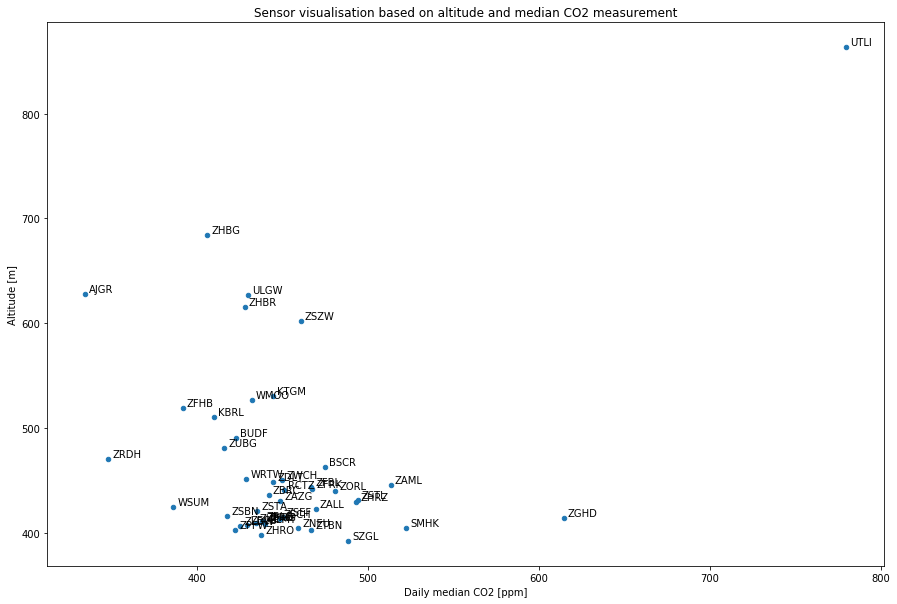

In [5]:
ax = ma.plot(x='CO2', y='altitude', kind='scatter', figsize=(15, 10))

for k, v in ma.iterrows():
    ax.annotate(k, v, xytext=(4,2), textcoords='offset points', fontsize=10)

plt.title('Sensor visualisation based on altitude and median CO2 measurement')
plt.xlabel('Daily median CO2 [ppm]')
plt.ylabel('Altitude [m]')
plt.show()

## Determin the correct value of k

In [73]:
def plot_elbow_method(ma, search_space = range(2,11) ):
   
    X = ma.values
    kmeans = [KMeans(i) for i in search_space]
    scores = [kmeans[i].fit(X).inertia_ for i in range(len(kmeans))]

    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    ax.plot(range_k, scores)
    plt.title('Elbow method for optimal K')
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of squared distances')
    plt.yticks([])
    plt.grid()
    plt.show()

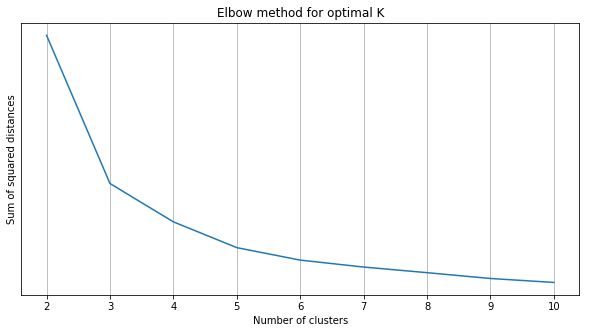

In [74]:
plot_elbow_method(ma)

In [ ]:
"""X = ma.values
range_k = range(2,11)
for k in range_k:
    cluster = KMeans(n_clusters=k)
    cluster_labels = cluster.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print('For K={}, the average silhouette score is {:1.5f}.'.format(k, silhouette_avg))"""

In [8]:
ma['altitude_cluster'] = KMeans(4).fit(X).labels_
ma.head()

,CO2,altitude,altitude_cluster
LocationName,,,
AJGR,334.785793,627.8,3
BSCR,475.316233,462.3,1
BUDF,422.793126,490.2,0
KBRL,410.100150,510.5,0
KTGM,444.395518,530.3,0


Retrieve the average wind speed in zurich  to perform the clustering


In [42]:
ZU_aw = zurich_average_wind.copy()
ZU_aw.set_index('timestamp', inplace=True)
ZU_aw.index = pd.to_datetime(ZU_aw.index)
ZU_aw.head()

,wind_speed
timestamp,
2017-10-01 00:00:00,2.330000
2017-10-01 00:30:00,1.480000
2017-10-01 01:00:00,0.950000
2017-10-01 01:30:00,0.923333
2017-10-01 02:00:00,0.776667


For each day generate a vector of size 48. since we have samples on a 30min interval

In [66]:

daily_sample = pd.DataFrame(columns=list(range(48)))

for index, row in ZU_aw.groupby(ZU_aw.index.day):
    day = row.index[0].date()
    daily_sample.loc[day] = row.values.T[0]

In [67]:
daily_sample.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
2017-10-01,2.330000,1.480000,0.950000,0.923333,0.776667,0.513333,1.380000,1.170000,0.716667,0.436667,...,0.710000,0.656667,1.116667,0.180000,0.156667,0.133333,0.510000,0.190000,0.733333,0.570000
2017-10-02,0.590000,0.673333,0.566667,0.026667,0.293333,0.606667,0.763333,0.316667,0.276667,0.470000,...,2.070000,3.203333,2.413333,1.916667,2.510000,1.766667,1.770000,3.420000,2.700000,2.426667
2017-10-03,2.863333,4.593333,4.746667,4.730000,3.673333,3.350000,3.760000,5.156667,5.776667,6.090000,...,0.256667,0.400000,0.723333,0.603333,0.156667,0.510000,0.820000,1.586667,1.706667,1.043333
2017-10-04,0.660000,0.480000,0.673333,0.466667,0.506667,0.576667,0.570000,0.323333,0.526667,0.523333,...,0.543333,0.400000,0.633333,0.616667,0.260000,0.400000,0.916667,0.173333,0.533333,0.556667
2017-10-05,0.276667,0.343333,0.386667,0.670000,1.093333,0.750000,0.566667,0.776667,0.863333,0.126667,...,5.936667,5.376667,5.183333,3.596667,1.640000,1.336667,0.593333,3.666667,3.543333,0.350000


We then apply pca to retrieve the 2 most important features

In [68]:
pca = decomposition.PCA(n_components=2)
pca_components = pd.DataFrame(columns=['component_1', 'component_2'], index=daily_sample.index)
components_values = pca.fit_transform(daily_sample.values)
pca_components.loc[:] = components_values
pca_components.index.names = ['timestamp']


In [69]:
pca_components.head()

,component_1,component_2
timestamp,,
2017-10-01,-4.106523,-1.663550
2017-10-02,-0.869377,4.207631
2017-10-03,8.023951,-8.309913
2017-10-04,-3.281485,-0.074907
2017-10-05,8.288445,11.560985


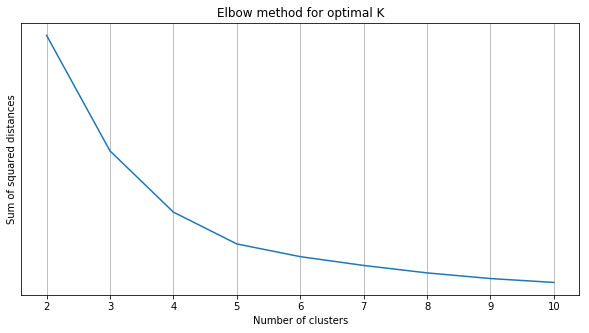

In [75]:
plot_elbow_method(pca_components)

In [77]:
mat = pca_components.values
km = KMeans(n_clusters=4)
km.fit(mat)
labels = km.labels_
pca_components['cluster'] = labels
pca_components.head()

,component_1,component_2,cluster
timestamp,,,
2017-10-01,-4.106523,-1.663550,1
2017-10-02,-0.869377,4.207631,0
2017-10-03,8.023951,-8.309913,2
2017-10-04,-3.281485,-0.074907,1
2017-10-05,8.288445,11.560985,0
